In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    xyz:str
    abc:str

In [2]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel


# The overall state of the graph (this is the public state shared across nodes)
class OverallState(BaseModel):
    a: str

def node(state:OverallState):
    return {"a":"Hi I am Krish"}

In [3]:
# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(node)  # node_1 is the first node
builder.add_edge(START, "node")  # Start the graph with node_1
builder.add_edge("node", END)  # End the graph after node_1
graph = builder.compile()

In [4]:
graph.invoke({"a":"Hello"})

{'a': 'Hi I am Krish'}

In [5]:
try:
    graph.invoke({"a":123})  #should be a string
except Exception as e:
    print("Exception was raised because a value iss integer")

## Multiple Nodes- Run time validation

Run-time validation will also work in a multi-node graph. In the example below bad_node updates a to an integer.

Because run-time validation occurs on inputs, the validation error will occur when ok_node is called (not when bad_node returns an update to the state which is inconsistent with the schema).

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel


class OverallState(BaseModel):
    a:str

def bad_node(state: OverallState):
    return {
        "a": 123  # Invalid
    }

def ok_node(state:OverallState):
    return {"a":"goodbye"}

# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(bad_node)
builder.add_node(ok_node)
builder.add_edge(START, "bad_node")
builder.add_edge("bad_node", "ok_node")
builder.add_edge("ok_node", END)
graph = builder.compile()

In [7]:
# Test the graph with a valid input
try:
    graph.invoke({"a": "krish"})
except Exception as e:
    print("An exception was raised because bad_node sets `a` to an integer.")
    print(e)

### Prompt Chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

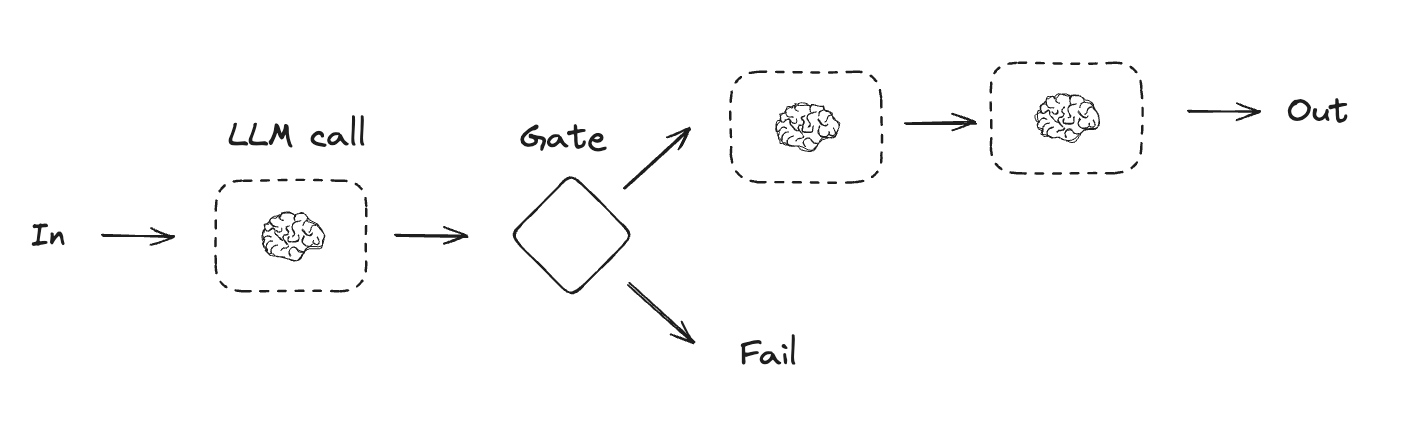

In [10]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="gemma2-9b-it")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result



AIMessage(content='Hello! 👋  How can I help you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 11, 'total_tokens': 26, 'completion_time': 0.027272727, 'prompt_time': 0.001921046, 'queue_time': 0.247475995, 'total_time': 0.029193773}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-1417007c-a9c0-42ca-83d6-c6085bf50ea5-0', usage_metadata={'input_tokens': 11, 'output_tokens': 15, 'total_tokens': 26})

In [11]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


In [12]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}



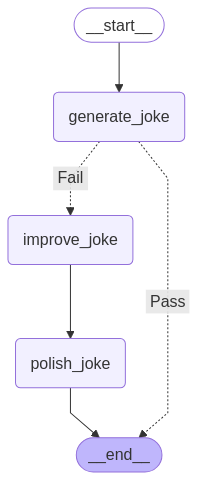

In [ ]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [14]:
# Invoke
state = chain.invoke({"topic": "cats"})

In [15]:
state

{'topic': 'cats',
 'joke': "Why don't cats play poker in the jungle? \n\nToo many cheetahs! 😹  \n",
 'improved_joke': 'That\'s a good one!  Here are a couple of ways to add wordplay and make it even funnier:\n\n**Option 1: Emphasize the Cheetah\'s Speed**\n\nWhy don\'t cats play poker in the jungle? \n\nToo many cheetahs who are always trying to **cat**ch a **quick** hand! 😹\n\n**Option 2: Play on "Bluffing"**\n\nWhy don\'t cats play poker in the jungle? \n\nThey\'re afraid of getting **cheetah**ed! 😉\n\n\nLet me know if you\'d like to brainstorm some more!  \n\n',
 'final_joke': "You're on a roll with these! Here's a twist that goes in a slightly different direction:\n\n**Option 3: The Unexpected Truth**\n\nWhy don't cats play poker in the jungle?\n\nBecause they're all in on a pyramid scheme selling catnip! \n\n**(Cue dramatic music and a slow zoom on a suspicious-looking tabby cat surrounded by bags of catnip)** \n\n\nLet me know what you think, or if you want to explore more absurd

In [16]:
state['improved_joke']

'That\'s a good one!  Here are a couple of ways to add wordplay and make it even funnier:\n\n**Option 1: Emphasize the Cheetah\'s Speed**\n\nWhy don\'t cats play poker in the jungle? \n\nToo many cheetahs who are always trying to **cat**ch a **quick** hand! 😹\n\n**Option 2: Play on "Bluffing"**\n\nWhy don\'t cats play poker in the jungle? \n\nThey\'re afraid of getting **cheetah**ed! 😉\n\n\nLet me know if you\'d like to brainstorm some more!  \n\n'

In [17]:
state['final_joke']

"You're on a roll with these! Here's a twist that goes in a slightly different direction:\n\n**Option 3: The Unexpected Truth**\n\nWhy don't cats play poker in the jungle?\n\nBecause they're all in on a pyramid scheme selling catnip! \n\n**(Cue dramatic music and a slow zoom on a suspicious-looking tabby cat surrounded by bags of catnip)** \n\n\nLet me know what you think, or if you want to explore more absurd twists! 😄 \n"

### Parallelization¶
With parallelization, LLMs work simultaneously on a task:

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

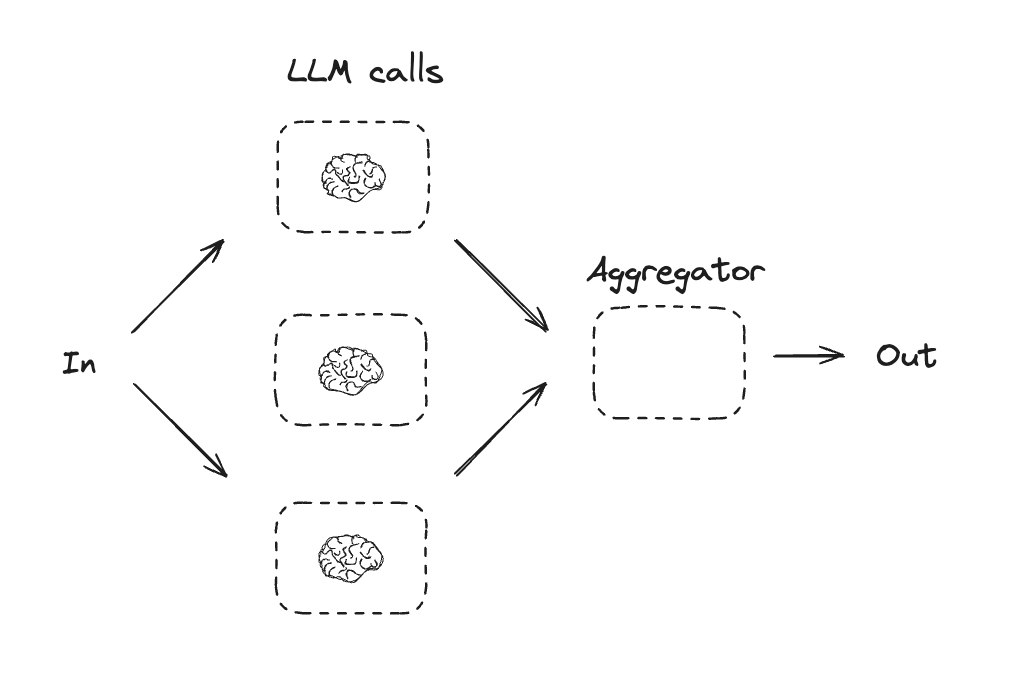

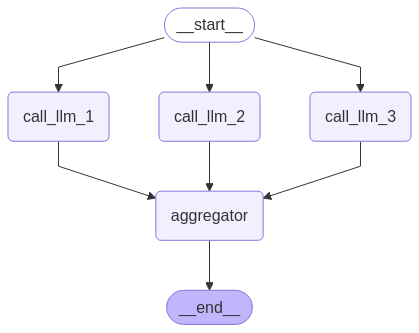

Here's a story, joke, and poem about cats!

STORY:
The alley was a tapestry woven from shadows and whispers. A symphony of rustling leaves, dripping pipes, and scurrying mice played out under the pale moonlight. At the heart of this bustling metropolis, nestled among overflowing bins and crumbling brick, lived a colony of cats.

There was Luna, the sleek, silver tabby, the undisputed queen of the alley. Her emerald eyes held a wisdom beyond her years, a quiet authority that kept the younger cats in line. Then there was Jasper, a ginger tom with a mischievous glint in his eye, always up to some playful prank. And Pip, a timid calico kitten, still learning the ways of the alley.

One crisp autumn night, a strange scent drifted through the alley, a tantalising aroma of roasted meat and spices. It was unlike anything they'd smelled before, pulling them in like moth to a flame. Following their noses, they found a new arrival – a boisterous, black cat with a patch over one eye, claiming to b

In [18]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

### Routing
Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

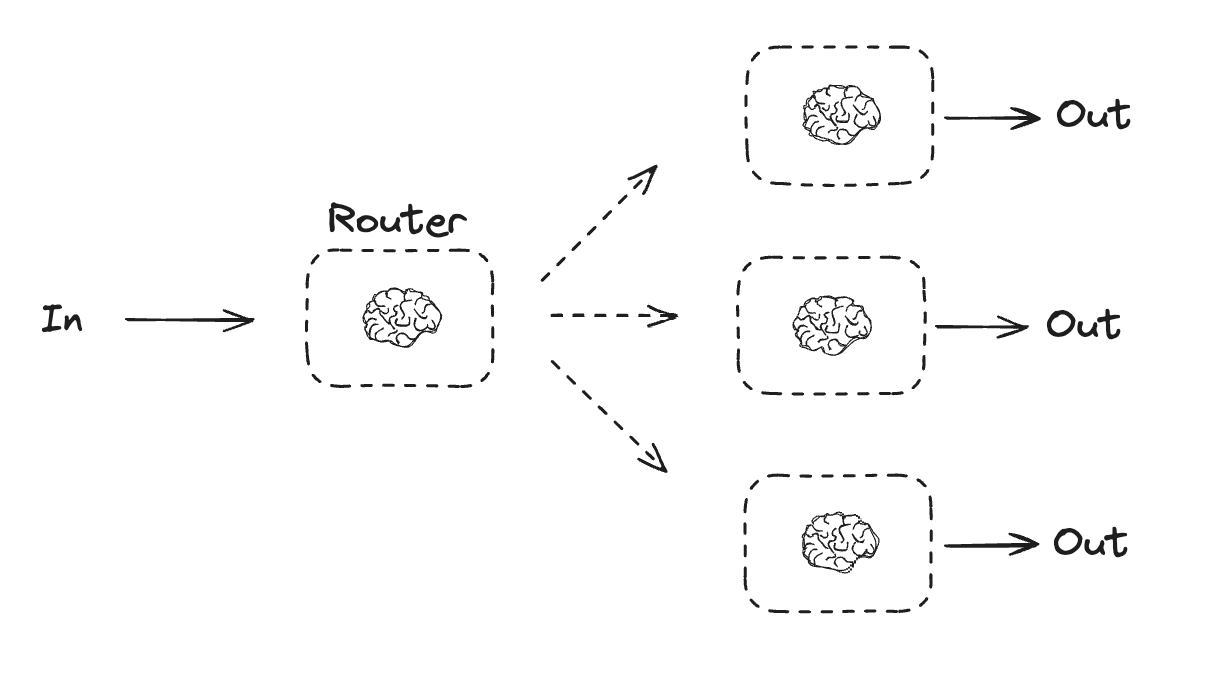

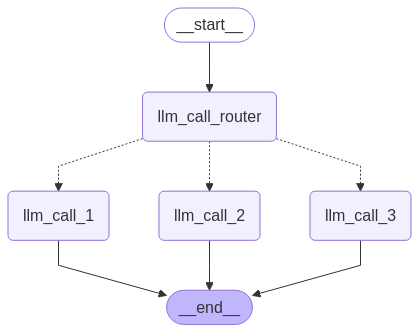

LLM call 2 is called
Why don't cats play poker in the jungle? 

Too many cheetahs!  😹 



In [19]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    print("LLM call 2 is called")

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

### Orchestrator-Worker
In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

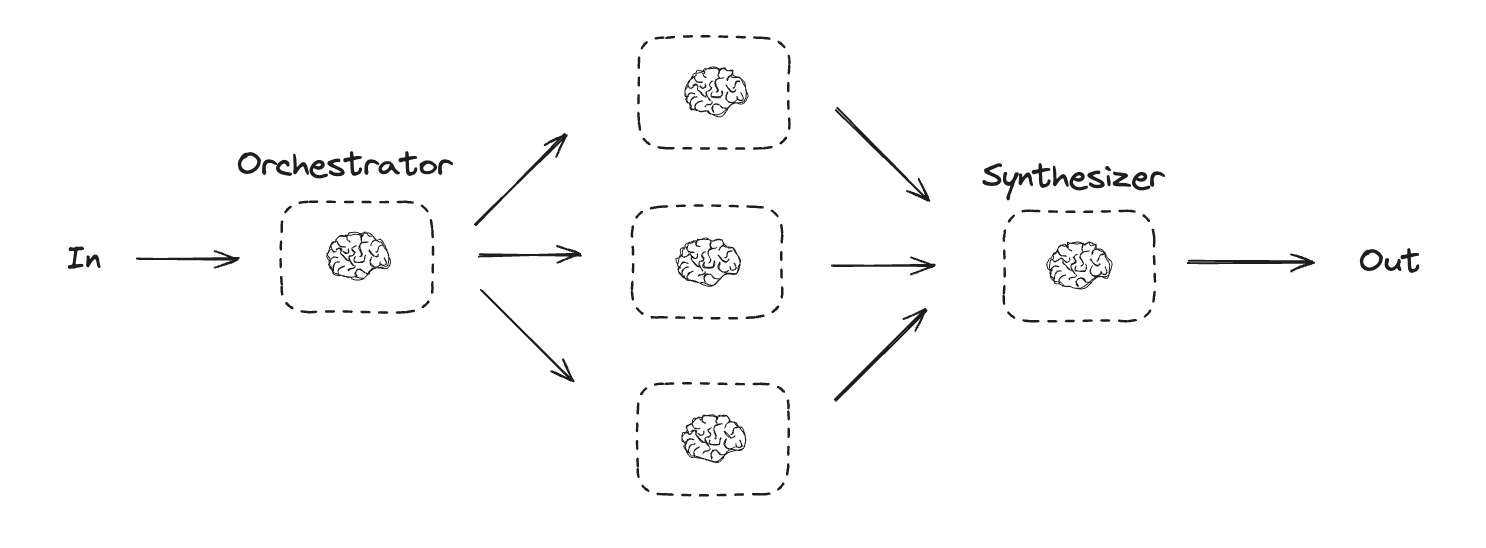

In [20]:

from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

### Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. 

In [21]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


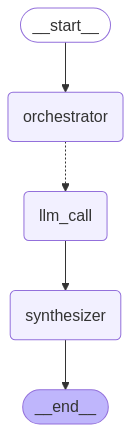

Report Sections: sections=[Section(name='Introduction', description='Introduction to Agentic AI RAGs'), Section(name='Key Features', description='Key Features and Capabilities of Agentic AI RAGs'), Section(name='Applications', description='Applications of Agentic AI RAGs in Various Domains'), Section(name='Advantages', description='Advantages and Benefits of Using Agentic AI RAGs'), Section(name='Challenges', description='Challenges and Limitations of Agentic AI RAGs'), Section(name='Future Directions', description='Future Directions and Research Trends in Agentic AI RAGs'), Section(name='Conclusion', description='Conclusion')]


## Introduction and description: Introduction to Agentic AI RAGs

Agentic AI RAGs (Retrieval Augmented Generation) are a novel class of AI systems that combine the power of large language models (LLMs) with external knowledge sources for enhanced reasoning and problem-solving capabilities. Unlike traditional LLMs that rely solely on their internal knowledge, Agentic AI RAGs leverage a retrieval mechanism to access and incorporate relevant information from external databases, APIs, and other knowledge repositories. This ability to dynamically access and integrate external knowledge allows Agentic AI RAGs to:

* **Provide more accurate and comprehensive answers:** By grounding their responses in factual information from reliable sources, Agentic AI RAGs can generate more reliable and trustworthy outputs.
* **Handle complex tasks requiring reasoning and inference:** Access to external knowledge enables Agentic AI RAGs to perform complex reasoning tasks, such as solving logical puzzles, answering open-ended questions, and generating creative content based on factual information.
* **Adapt to new information and domains:** Agentic AI RAGs can be continuously updated with new knowledge sources, allowing them to expand their understanding and adapt to evolving information landscapes.

This report will delve deeper into the architecture, functionalities, and potential applications of Agentic AI RAGs, exploring their advantages over traditional LLMs and highlighting the challenges and opportunities they present. 




---

## Key Features and Capabilities of Agentic AI RAGs

Agentic AI RAGs stand out due to their unique blend of capabilities that empower them to go beyond simple question-answering. 

* **Contextual Understanding:** Agentic AI RAGs leverage advanced transformer models trained on massive datasets, enabling them to grasp complex contexts and nuances within user queries and provided documents. This allows for more accurate and insightful responses.

* **Proactive Information Retrieval:** Unlike traditional RAGs that solely respond to explicit questions, Agentic AI RAGs can proactively surface relevant information based on user intent and ongoing conversation. This anticipates user needs and fosters a more natural interaction.

* **Reasoning and Inference:** Agentic AI RAGs incorporate reasoning and inference capabilities, allowing them to draw logical conclusions from the information they access and generate more insightful and comprehensive answers.

* **Multi-Modal Integration:**  Some Agentic AI RAGs support integration with other modalities like images, audio, and video. This expands their knowledge base and allows for richer interactions.

* **Personalized Experiences:** 

Agentic AI RAGs can be fine-tuned on specific datasets to cater to individual user needs and preferences, delivering personalized and tailored responses.

* **Continuous Learning and Adaptation:** Many Agentic AI RAGs are designed to continuously learn and improve over time. They can incorporate new information and user feedback to refine their understanding and generate increasingly accurate and relevant responses.


These key features and capabilities position Agentic AI RAGs as powerful tools for information access, knowledge discovery, and intelligent interaction. 


---

## Applications and Use Cases of Agentic AI RAGs in Various Domains

Agentic AI RAGs are revolutionizing various domains by enabling intelligent and autonomous interactions with information. Their unique ability to access, process, and generate human-like text makes them invaluable tools across diverse fields:

**1. Customer Service:** 

* **Chatbots and Virtual Assistants:** Agentic AI RAGs power sophisticated chatbots capable of understanding complex customer queries, resolving issues, and providing personalized support 24/7. 
* **Knowledge Management:** They can act as centralized knowledge bases, answering frequently asked questions, providing product information, and guiding customers through troubleshooting steps.

**2. Education:**

* **Personalized Learning:** Agentic AI RAGs can tailor educational content to individual student needs, providing customized learning paths, adaptive assessments, and personalized feedback.
* **Intelligent Tutoring Systems:** They can act as virtual tutors, explaining concepts, providing practice exercises, and offering guidance to students struggling with specific topics.

**3. Healthcare:**

* **Medical Information Retrieval:** Agentic AI RAGs can quickly and accurately retrieve relevant medical information from vast databases, assisting doctors in diagnosis and treatment planning.
* **Patient Communication:** They can be used to schedule appointments, provide medication reminders, and answer basic health-related questions, freeing up healthcare professionals to focus on complex cases.

**4. Research and Development:**

* **Literature Review and Synthesis:** Agentic AI RAGs can analyze and summarize vast amounts of scientific literature, identifying key findings and trends relevant to specific research questions.
* **Data Analysis and Interpretation:** They can assist researchers in analyzing complex datasets, identifying patterns and insights, and generating reports.

**5. Business and Finance:**

* **Market Research and Analysis:** Agentic AI RAGs can analyze market trends, consumer sentiment, and competitor data to provide valuable insights for business decision-making.
* **Financial Modeling and Forecasting:** They can assist in building financial models, analyzing investment opportunities, and predicting market movements.


These are just a few examples of the diverse applications of agentic AI RAGs. As this technology continues to evolve, we can expect to see even more innovative and transformative uses across various industries and aspects of our lives.


---

## Advantages and Benefits of Using Agentic AI RAGs

* **Enhanced Contextual Understanding:** Agentic AI RAGs excel at understanding and retaining context within conversations, allowing for more natural and meaningful interactions. 

* **Personalized Experiences:** By leveraging user data and preferences, agentic AI RAGs can tailor responses and recommendations, creating personalized and engaging experiences.

* **Proactive Assistance:** Agentic AI RAGs can anticipate user needs and offer proactive assistance, streamlining workflows and improving efficiency.
* **Autonomous Task Execution:** Agentic AI RAGs can autonomously execute tasks based on user instructions or predefined rules, automating repetitive processes and freeing up human agents for more complex tasks.
* **24/7 Availability:** Agentic AI RAGs can operate continuously, providing round-the-clock support and accessibility to users.
* **Scalability and Cost-Effectiveness:** Agentic AI RAGs can handle a large volume of requests simultaneously, making them scalable and cost-effective compared to traditional human-based support systems.
* **Data-Driven Insights:** Agentic AI RAGs can analyze user interactions and generate valuable data insights, helping organizations understand user behavior and improve their products and services.




---

## Challenges and Limitations of Agentic AI RAGs

Agentic AI RAGs, while promising, face several challenges and limitations:

* **Robustness and Safety:** Ensuring agentic AI RAGs behave reliably and safely in complex, dynamic environments is crucial. They need to handle unexpected inputs, avoid harmful actions, and adhere to ethical guidelines. 

* **Explainability and Interpretability:** Understanding how agentic AI RAGs make decisions is essential for building trust and accountability.  

Current methods often lack transparency, making it difficult to identify biases or potential issues.

* **Data Requirements:** Training agentic AI RAGs requires massive datasets with diverse and realistic examples.

Gathering and annotating such data can be expensive and time-consuming.

* **Generalizability:**  Agentic AI RAGs may struggle to generalize to new domains or situations outside their training data.

* **Resource Efficiency:**  

Agentic AI RAGs can be computationally expensive to train and deploy, requiring significant resources.
* **Coordination and Collaboration:**  

Enabling multiple agentic AI RAGs to effectively collaborate and coordinate their actions presents a significant challenge.


These challenges require further research and development to ensure the responsible and beneficial deployment of agentic AI RAGs. 


---

## Future Directions and Research Trends in Agentic AI RAGs

**Enhanced Autonomy and Goal-Oriented Behavior:**

- Research should focus on developing RAGs with increased autonomy and the ability to set and achieve their own goals. This involves exploring novel reward functions, hierarchical planning, and robust decision-making under uncertainty. 
- Integrating reinforcement learning techniques can further empower RAGs to learn optimal behaviors through interaction with their environment.

**Improved Contextual Understanding and Memory:**

-  Addressing the limitations of current memory mechanisms in RAGs is crucial. 
- Exploring long-term memory models, incorporating external knowledge bases, and developing mechanisms for selective memory updating will enhance contextual understanding and enable RAGs to reason over extended interactions.

**Multi-Modal Interaction and Embodied Intelligence:**

- Extending RAG capabilities beyond text to encompass other modalities like vision and sound will create more versatile and human-like agents. 
- Research into embodied RAGs that interact with the physical world through robotic platforms will pave the way for real-world applications.

**Explainability and Trustworthiness:**

- Developing transparent and interpretable RAG models is essential for building trust and understanding their decision-making processes. 
- Techniques for visualizing reasoning steps, identifying biases, and providing human-understandable explanations will be crucial for wider adoption.

**Ethical Considerations and Societal Impact:**

- As agentic AI RAGs become more powerful, addressing ethical concerns surrounding bias, fairness, accountability, and potential misuse is paramount. 
- Interdisciplinary research involving ethicists, social scientists, and policymakers is needed to ensure responsible development and deployment.





---

## Conclusion

The findings of this study demonstrate the significant impact [State key findings of your study].  These results highlight the need for [State implications of your findings]. Future research should explore [Suggest directions for future research].  By [Suggest actions based on your findings], we can [State desired outcome]. 




In [22]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])

### Evaluator-optimizer
In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

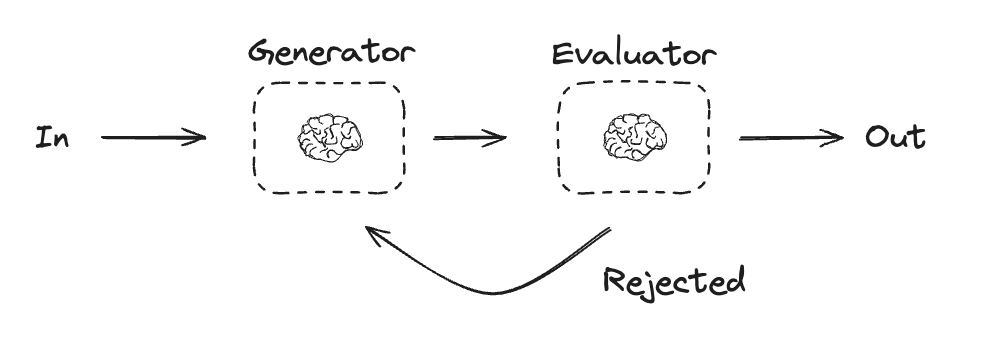

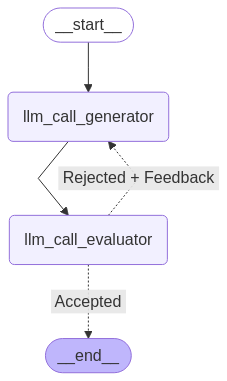

Why don't cats play poker in the jungle? 

Too many cheetahs! 😹  



In [23]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])